In [125]:
import numpy as np
import matplotlib.pyplot as plt
import importlib 

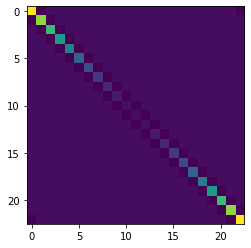

In [126]:
import transmon
importlib.reload(transmon)

defining_dict = {
    "n_cutoff":         11,
    "e":                1.519e6,    # GHz / voltage 
    "EJ":               50,         # GHz hbar
    "EJ_EC_ratio":      10, 
    "gamma":            2.5
}
circuit = transmon.Transmon(defining_dict)
plt.imshow(circuit.Hamiltonian().todense())

## Try earlier exercise
__Some fixes are needed here. Is energy rescaling allowed?__

(0.0, 301.2349804343109)

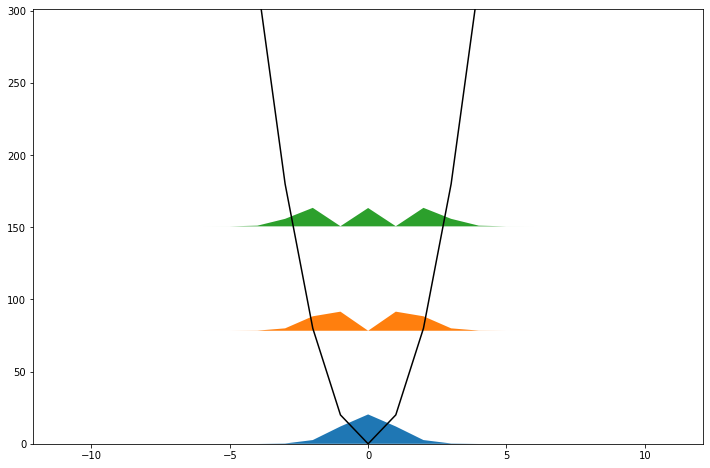

In [127]:
V = circuit.V()
H = circuit.Hamiltonian()
n = circuit.charge()
T = circuit.fourier_transform_matrix()

from scipy.sparse.linalg import eigsh 
Es, Psis = eigsh(H, k = 3, which = "SA")
Es      -= Es[0]

fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(n, V, color = "k")


for i, E in enumerate(Es):
    ax.fill_between(n, E,  E + 50 * abs(Psis[:, i]) ** 2, label = i)

ax.set_ylim(0, 2 * Es[-1])

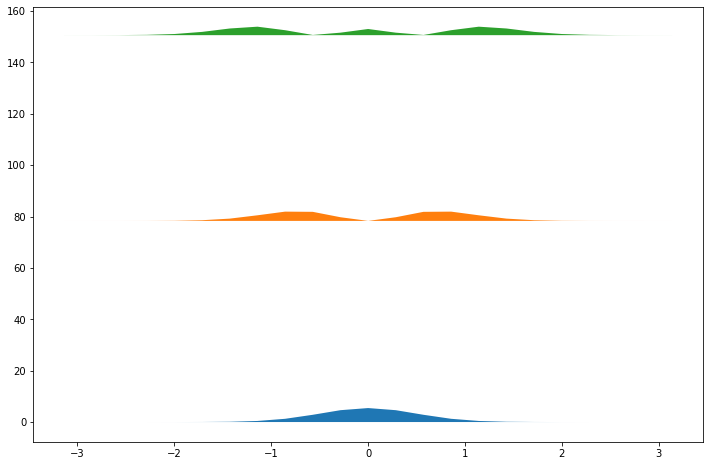

In [128]:
fig, ax = plt.subplots(figsize = (12, 8))
phis = np.linspace(-np.pi, np.pi, Psis.shape[0])

for i, E in enumerate(Es):
    ax.fill_between(phis, E,  E + 25 * abs(T @ Psis[:, i]) ** 2, label = i)

## Convert to density matrices

In [143]:
# Meta 
amount_of_states = 3

# Circuit 
transmon_dict = {
    "n_cutoff":         11,
    "e":                1.519e6,    # GHz / voltage 
    "EJ":               1,         # GHz hbar
    "EJ_EC_ratio":      10, 
    "gamma":            2.5
}

# Pulse
psi0      = (1, 0, 0)
phase     = 0
envelope  = "gaussian"
duration  = (0, 100) 

args     = {"T": 50, "width": 10}

###############################################################
import transmon
importlib.reload(transmon)


circuit = transmon.Transmon(transmon_dict)

# Get circuit params
V = circuit.V()
H = circuit.Hamiltonian()
n = circuit.charge()
T = circuit.fourier_transform_matrix()

# Matrix for n
n_matrix = circuit.n_matrix()

from scipy.sparse.linalg import eigsh
Es, psis = eigsh(H, k = amount_of_states, which = "SA")



# Pulse Generation
PulseGenerator = transmon.PulseGenerator(omega = Es[1] - Es[0], envelope = envelope, arguments = args)

In [144]:
# We define H0 from the energies. It is diagonal
H0 = np.diag(Es - Es[0]).astype(np.complex128)

# The driving hamiltonian is found from overlaps by the n_element
H_overlap = np.conjugate(psis).T @ n_matrix @ psis
H_overlap = H_overlap.astype(np.complex128)

g1        = H_overlap[0, 1]

# Pulse
pulse = PulseGenerator.total_func()

# Time dependent Hamiltonian
def H(t):
    return H0 + pulse(t, phase) / 2 / g1 * H_overlap


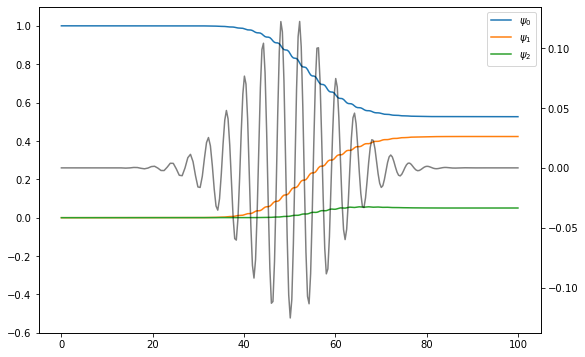

In [145]:
# Simulation
from scipy.integrate import solve_ivp

# Schödinger
def diff_equation(t, y):
     H_of_t = H(t)
     dy     = - 1j * H_of_t @ y.T
     return dy

# Solve
results = solve_ivp(diff_equation, t_span = duration, y0 = np.asarray(psi0, dtype = np.complex128), method = "RK45")


# Plot the dynamics
fig, ax = plt.subplots(figsize = (9, 6))
ax.plot(results.t, abs(results.y[0,:])**2, label = "$\psi_0$")
ax.plot(results.t, abs(results.y[1,:])**2, label = "$\psi_1$")
ax.plot(results.t, abs(results.y[2,:])**2, label = "$\psi_2$")
ax.set_ylim(-0.6, 1.1)

ax1 = ax.twinx()
ax1.plot(results.t, pulse(results.t), "k", label = "pulse", alpha = 0.5)
# ax1.set_ylim(-3, 15)
ax.legend()